*"In this work, we thus tasked ourselves to find out whether...negative examples are indispensable to prevent collapsing while preserving high performance."* -- the BYOL paper

## References:

This post is indebted to
* [The Bootstrap Your Own Latent (BYOL) paper](https://arxiv.org/pdf/2006.07733.pdf) by Grill et al -- you could just stop reading my blog and read that, it's not a scary paper! (And yes, actually use the arXiv version because it's got extra figures not in the NeurIPS version I found.)   
* The [wonderful tutorial from The AI Summer](https://theaisummer.com/byol/) by Nikolas Adaloglou
* The ["BYOL-A: BYOL for Audio" paper](https://arxiv.org/pdf/2103.06695.pdf) by Nizumi et al
* The [`byol-pytorch`](https://github.com/lucidrains/byol-pytorch) code repository by Phil Wang aka lucidrains

## Review
Previously, on "Trying to Understand Embeddings, with Scott", i.e. [Part 3 of my blog series](https://drscotthawley.github.io/blog/2021/08/01/Live-CL-Demo.html), we'd worked out way to think of embeddings, and contrastive losses, and even built a toy model. 

In the toy model there were pairwise losses (boo!) and triplet losses (yay!), and even an "Attract Only" option whereby we got rid of 'repulsion' entirely. After the "Attract Only" ran, we would rescale the answers and that rescaling would produce a kind of "repulsion".  In that sense, the "Attract Only" method was one way to "remove the contrastive loss" thing. 

...uh... but as far as I know, nobody does that.  The [SimCLR](https://arxiv.org/abs/2002.05709) ("sim-clear") method mentioned a bit in earlier posts and elsewhere is one way of dealing with the problem of finding "challenging" negative examples, by working on a kind of "attraction", but not as naive as the toy model I made. 


BYOL is another way to simplify 'contrastive' learning and avoid hard-negative mining and it seems a bit like "attract only" in that it no longer means *explicitly* including a respulsive term in the loss function, but BYOL different from SimCLR and not as naive as my own scheme.  Instead, BYOL, uses an another network to do some comparisons. 

Recal that the goal of these systems is to get "good", "semantically meaningful" representations, however we can.  If it takes multiple networks to do that, no worries.

In [Part 2](https://drscotthawley.github.io/blog/scottergories/2021/06/17/Contrasting-Contrastive-Loss.html) of this blog series, we looked at Siamese Networks, where two copies of the same network are employed for pairwise contrastive learning.  With BYOL however, the two networks have the same architectures but *different weights*, and this difference helps to force "semantically interesting" embedding choices.

> **Anthropomorphism**: The use of two very different networks to try to arrive at similar embedding points is akin to having two very different people talk about something (while each trying on lots of very different funny-colored eyeglasses!) and iteratively refine their understanding through discussion until they can come to (some sufficient level of) agreement.

## Strategy: How we're going to do this
I'm a firm believer in toy models, so my plan is to use the [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset and then BYOL-embed a 3-dimensional set of represenations that we can look at and play with.

Oh, and since BYOL is a self-supervised method, we're going to *throw away the labels* from Fashion-MNIST ;-). 

## How BYOL Works

### In Diagrams

First let's steal multiple diagrams that all attempt to show the same thing.

From the original BYOL paper, we have this one: 
![byol_orig_process](images/byol_orig_proc_diagram.png)

> *"BYOL’s goal is to learn a representation $y_\theta$ which can then be used for downstream tasks."* -- the BYOL paper.  

> So beyond the "representation" parts we want to ultimately use, we'll tack on additional "projection" parts (and even a "prediction" part) to facilitate the training. 

Later in the BYOL paper (Figure 8), we have this version:
![byol_aisummer_process](images/byol_aisummer_proc.png)

And from the BYOL-A paper we have this version: 
![byol-a process diagram](images/byola_proc_diagram.png)

In each case, what we see are 3 main parts:

1. A single input ($x$) gets modified in two different ways ($v$ and $v')$. The two different ways are termed *views*.  
2. Each view is sent through a different network ("online" or "target") and gets mapped to the *same* embedding space.  
3. Then the loss/training is about minimizing the distance between those points in the embeddings space. 

:::{.callout-note}

there is only minimizing, i.e. "attraction" going on. There is no "repulsion".

:::

Those were broad strokes.  What about the details?  What about the "exponential moving average" bit, and the $q_\theta(z_\theta)$ and $z'_\xi$, and that...equation?  We'll get there. 

> Note also that we don't "want to keep" those points $q_\theta(z_\theta)$ and $z'_\xi$, they're just used along the way to help us learn the representations $y_\theta$. 

### Contrastive Learning Without Contrastive Loss, via Different Networks

The two networks aren't *totally* different.  If you look at the second diagram above (with the dogs), you'll see that the the first couple layers (in yellow) are of the same types: ResNet then MLP.  They don't have the same weights, but the weights are "related". 

And one of the networks (the "target") learns "slower" than the other ("online") network... in a sense.  This is the "exponential moving average" (EMA) part. EMA gets used in many contexts in machine learning (ML) to try to help keep things stable so that the system doesn't jump around too much, i.e. to keep the system from behaving erratically.  Think of reinforcement learning, where you want your robot to smoothly improve its position information instead of undergoing wild overcorrections. 

:::{.callout-note}

In some ML contexts, the slower-learning network is called the "teacher" rather than the "target", and the "online" network is termed the "student". [Here's a link for an influential paper on "Teacher-Student" models](https://paperswithcode.com/paper/knowledge-distillation-and-student-teacher).  I find this terminology to be counter-intutitive because in the BYOL case the "student" would be *teaching* the "teacher".

:::

The target network gets its weights *only* from the EMA of the corresponding weights in the online network.  The target weights are not obtained via gradient descent; only the online weights are updated via gradient descent.)  In other words, if the online weights are $\theta$ and the target weights are $\xi$, then the EMA operation consists of

$$\xi \leftarrow \tau \xi + (1 - \tau) \theta, $$
for some choice of the "EMA spread/strength" (hyper)parameter $\tau$. 

The terms "target" and "online" can also refer to the representation "points" in the embedding space. Using such terminology, the BYOL paper explains the method this way: 

> *"the core
motivation for BYOL: from a given representation, referred to as target, we can train a new, potentially
enhanced representation, referred to as online, by predicting the target representation. From there, we
can expect to build a sequence of representations of increasing quality by iterating this procedure, using subsequent online networks as new target networks for further training..."*

...i.e. we update the target (a bit, using the EMA) and do it all again. 

Ok, so then what's with the extra "projection" and "prediction" layers?  

### The Mapping Functions

:::{.callout-note}

The BYOL authors use the subscript "${}_\theta$" to refer to weights in the online network, and the subscript "${}_\xi$" to refer to weights in the target network.  Vectors in the target network are also denoted via primes, e.g., $v'$, $y'$, $z'$.

:::

* **Encoder $f$** ($f_\theta$ and $f_\xi$): Views (i.e., $v$ and $v'$, i.e., augmented versions of the input $x$) are mapped to embeddings $y$ ($y_\theta$ in the online network) via the "encoder" function $f$ ($f_\theta$ online). And remember, *"BYOL’s goal is to learn a representation $y_\theta$ which can then be used for downstream tasks."*  For images, $f$ is typically a ResNet. 

* **Projector $g$** ($g_\theta$ and $g_\xi$): Maps the embeddings $y$ to points $z$ in the space where loss will be evaluated. In particular, $z'_\xi$ is important because it's a point output by the target network, which the online network is going to try to "predict".  $g$ can just be an MLP (though see below for comments about BatchNorm).

* **Predictor $q_\theta$**: is only on the online network.  The predictors output $q_\theta(z_\theta)$ is the online network's *prediction* of the target network's output $z'_\xi$.  

### Hold up: Questions

1. Why's the predictor there at all?  In other words, why can't we just compare $z_\theta$ and $z'_\xi$ without this additional $q_\theta$ function?  

2. And for that matter, why can't we just compare $y_\theta$ and $y'_\xi$ directly? 

Let's answer these in reverse order: 

<ol start="2" reversed="reversed">
    <li>Comparing $y_\theta$ and $y'_\xi$ is what we were already doing before with ordinary contrastive losses.</li>
    <li>And then SimCLR came along and introduced an additional mapping function akin to our "projector" $g$ in which we could compare $z_\theta$ and $z'_\xi$ -- so that's been tried already.  And it does work quite well for assisting with contrastive representation learning without having to worry to much about finding "hard negatives".</li>
</ol>

But now we're trying something different, with the goal of avoiding negative examples (i.e. contrastive losses) and the goal of...beating SimCLR. ;-) So bear with this discussion!

### The Loss
We define a loss in the "projected" space between the points $q_\theta(z_\theta)$ and $z'_\xi$, that's just the ordinary mean L2 norm ("Euclidean distance") between them. So

$$\mathcal{L}_{\theta\xi}= ||\bar{q_{\theta}}(z_\theta) - \bar{z}'_\xi||_2^2$$

Or you can write it in terms of a dot product normalized by the magnitudes, which is what we see written in the BYOL paper: 

$$\mathcal{L}_{\theta\xi} = 2 - 2\cdot\frac{\langle q_\theta(z_\theta),  z'_\xi \rangle }{\big\|q_\theta(z_\theta)\big\|_2\cdot \big\|z'_\xi\big\|_2  }
$$

If that reminds you of a cosine similarity -- good, because that's exactly what it is. See, the graph of $2(1-\cos x)$ has a nice minimum when its argument is zero, kind of like a parabola on a certain domain:

[<matplotlib.lines.Line2D>]

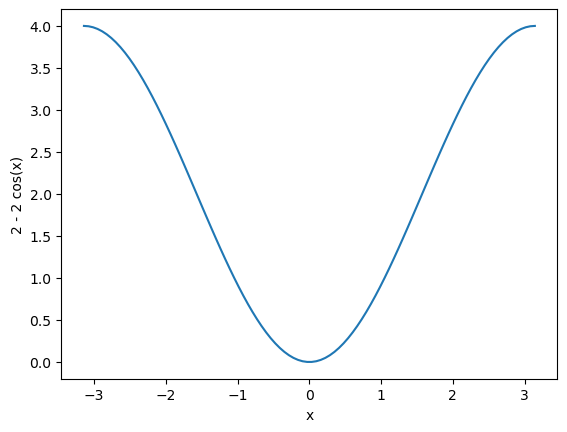

In [ ]:
#|hide
import matplotlib.pyplot as plt
import numpy as np 
x = np.linspace(-np.pi, np.pi,num=100)
plt.xlabel('x')
plt.ylabel('2 - 2 cos(x)')
plt.plot(x, 2*(1-np.cos(x)))

One other thing they do is to "symmetrize" the loss by also passing $v'$ through the online network and passing $v$ through the target network, to compute what they call $\tilde{\mathcal{L}}_{\xi\theta}$, and then the full loss is the sum of these two losses:

$$\mathcal{L}^{\rm BYOL} = \mathcal{L}_{\theta\xi} + \tilde{\mathcal{L}}_{\xi\theta}$$

### Further Theory-Reading
* Still you may ask, "But whyyyyyyy does this work?" Here's a good paper that tries to answer just that: ["Understanding self-supervised Learning Dynamics without Contrastive Pairs"](https://arxiv.org/abs/2102.06810) by Tian et al (2021). 
* "What's up with the batch norm / group norm stuff that appears in some discussions of BYOL?" (which I may or may not have mentioned above, LOL):  See ["BYOL works even without batch statistics"](https://arxiv.org/abs/2010.10241) by Richemond et al (2020).

## Let's Go!  Quick Implemenation for Images

In a later post we can talk about writing our own implmentation from scratch (e.g. for  something other than images, such as audio).  But to just get started with all this, 
what better place to start a coding implementation than [lucidrains' repository](https://github.com/lucidrains/byol-pytorch)? It's super easy to install: 

In [ ]:
%pip -qq install byol-pytorch

Note: you may need to restart the kernel to use updated packages.


...and we can just "tack it on" to whatever network/task we might have.  He provides a sample use case in his README which we'll modify slightly.  First, he sets up a simple test using random images, which we'll run a version of now:

In [ ]:
import torch
from byol_pytorch import BYOL 
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm_notebook

In [ ]:
resnet = models.resnet50(weights=True) # this will download resnet50 weights. 

device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
if torch.device('cpu') == device: print("Warning: Running on the CPU.")

image_size = 28   # size for fashion mnist images

learner = BYOL(     # lucidrains' class
    resnet,
    image_size = image_size,
    hidden_layer = 'avgpool'
).to(device)

opt = torch.optim.Adam(learner.parameters(), lr=3e-4)

def sample_unlabelled_images():
    return torch.randn(20, 3, image_size, image_size).to(device)  # make batch of 20 RGB images from random pixels.

for i in tqdm_notebook(range(50)):
    images = sample_unlabelled_images()
    loss = learner(images)
    opt.zero_grad()
    loss.backward()
    opt.step()
    learner.update_moving_average() # update moving average of target encoder

  0%|          | 0/50 [00:00<?, ?it/s]

Great! It works!

Now, rather than using random images, we'll use Fashion-MNIST. Let's get the data...

In [ ]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

batch_size = 128
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)

And... we should note that we don't *have* to use ResNet50 -- in fact, we don't have to use ResNet-Anything! We could specify some other model, which for our dataset, a very simple model could suffice.  

And/or, rather than a classifcation model, we could choose something like a U-Net, and then try to get the "interior" represenation of the U-Net to offer a more interesting represenation than it otherwise might. 

For now, just to avoid having to deviate from lucidrains' demo much,  we will stick with pretrained ResNet and just "drop down" in complexity to `resnet18`: 

In [ ]:
resnet = models.resnet18(weights=True) # reset resnet weights. 

learner = BYOL(
    resnet, 
    image_size=28, 
    hidden_layer = 'avgpool', # activations from this layer will be used as y_theta!
    use_momentum = True # set to false for 'SimSiam' variant. https://arxiv.org/abs/2011.10566
).to(device)

def train_it(learner, lr=3e-4, epochs=5, steps=200):
    opt = torch.optim.Adam(learner.parameters(), lr=lr)
    for e in range(epochs): 
        pbar = tqdm_notebook(range(steps), desc=f"Epoch {e}/{epochs}: ")
        for i in pbar:
            images, labels = next(iter(train_dataloader))
            images = images.to(device).tile([1,3,1,1]) # put on GPU & create RGB from greyscale
            loss = learner(images)
            pbar.set_postfix({'loss':f"{loss.detach():.3g}"})
            pbar.refresh()
            opt.zero_grad()
            loss.backward()
            opt.step()
            learner.update_moving_average() # update moving average of target encoder
            
train_it(learner) # operates on learner & resnet in-place

Epoch 0/5:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1/5:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/200 [00:00<?, ?it/s]

### Inspecting Our Results
How do we access and inspect the representations learned from this? lucidrains' README tells us that we already specified that:

> the name (or index) of the hidden layer, whose output is used as the latent representation used for self-supervised training.

...So we specified the layer named "`avgpool`" as the layer of our network `resnet` whose activations will serve as our learned representations.  We can print out the names of the layers to see where `avgpool` is (look way near the bottom):

In [ ]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

So pretty much all the way at the end, just before the last Linear layer.  Let's see how we can get these layer outputs / activations: 

In [ ]:
# get some mo' images
images, labels = next(iter(train_dataloader))
images = images.to(device).tile([1,3,1,1]) # put on GPU & create RGB from greyscale
images.shape

torch.Size([128, 3, 28, 28])

One way is to use some code we can find in lucidrains' source code...

In [ ]:
reps = learner.online_encoder.get_representation(images)
reps.shape

torch.Size([128, 512])

But the 'classic' way to do this in PyTorch is to [register a "forward hook"](https://discuss.pytorch.org/t/how-can-l-load-my-best-model-as-a-feature-extractor-evaluator/17254/6), as in:

In [ ]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

resnet.avgpool.register_forward_hook(get_activation('avgpool'))
output = resnet(images)
reps = activation['avgpool'].squeeze()
reps.shape

torch.Size([128, 512])

Note that our images are 28x28=784 monochrome pixels, so a "representation" via 512 points does not make much of a compression. ....But at this point, you can see the basics of how this works. 

No promises, but I may do a later version of this blog where we write our BYOL code from scratch, and/or use a U-Net or some other architecture, and/or look more closely into BYOL-A, but for now, this seems like a reasonable stopping point. :-)